<a href="https://colab.research.google.com/github/andres4ramos/167/blob/main/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [5]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-ukmu087h
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-ukmu087h
  Resolved https://github.com/greydanus/mnist1d to commit 68cb6b2d1d3a956cc2e9035e5a9860b66e33d642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [4]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [7]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions

# Define a model with two hidden layers of size 100 and ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),    # Input to first hidden layer
    torch.nn.ReLU(),              # ReLU activation
    torch.nn.Linear(D_k, D_k),    # First hidden to second hidden layer
    torch.nn.ReLU(),              # ReLU activation
    torch.nn.Linear(D_k, D_o)     # Second hidden to output layer
)

def weights_init(layer_in):
    # Initialize the parameters with He initialization
    if isinstance(layer_in, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            torch.nn.init.zeros_(layer_in.bias)
    print(f"Initializing layer: {layer_in}")

# Call the function you just defined
model.apply(weights_init)


Initializing layer: Linear(in_features=40, out_features=100, bias=True)
Initializing layer: ReLU()
Initializing layer: Linear(in_features=100, out_features=100, bias=True)
Initializing layer: ReLU()
Initializing layer: Linear(in_features=100, out_features=10, bias=True)
Initializing layer: Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=False, worker_init_fn=np.random.seed(1))

model.apply(weights_init)

n_epoch = 50
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
    for i, batch in enumerate(data_loader):
        x_batch, y_batch = batch
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()

    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test[epoch] = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train[epoch] = loss_function(pred_train, y_train).item()
    losses_test[epoch] = loss_function(pred_test, y_test).item()
    print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f}, test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

    scheduler.step()


Initializing layer: Linear(in_features=40, out_features=100, bias=True)
Initializing layer: ReLU()
Initializing layer: Linear(in_features=100, out_features=100, bias=True)
Initializing layer: ReLU()
Initializing layer: Linear(in_features=100, out_features=10, bias=True)
Initializing layer: Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)
Epoch     0, train loss 2.067737, train error 77.57, test loss 2.079963, test error 79.80
Epoch     1, train loss 1.859806, train error 71.05, test loss 1.892985, test error 74.40
Epoch     2, train loss 1.750740, train error 66.95, test loss 1.798964, test error 71.90
Epoch     3, train loss 1.679461, train error 64.03, test loss 1.741348, test error 69.30
Epoch     4, train loss 1.625199, train error 61.30, test loss 1.699172, test error 68.00
Epoch     5, train loss 1.580655, train

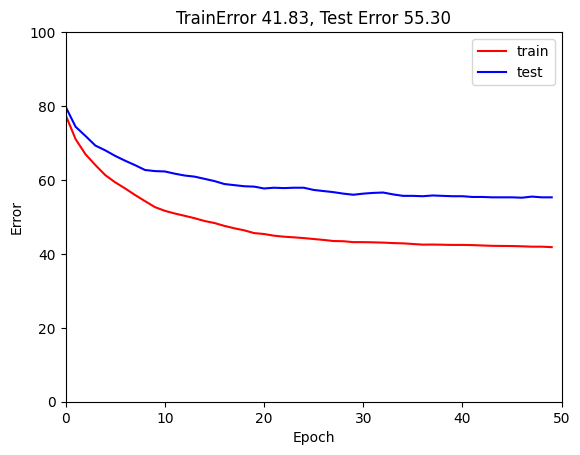

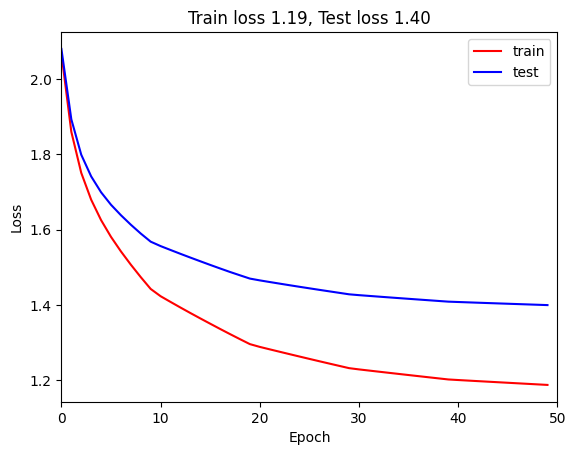

In [11]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

Answer:Manually adjusting settings like learning rate and momentum can help, but it might not show how well the model will really work. Using cross-validation is a better way to see if the model will perform well on new data.






